# LangChain Expression Language (LCEL)

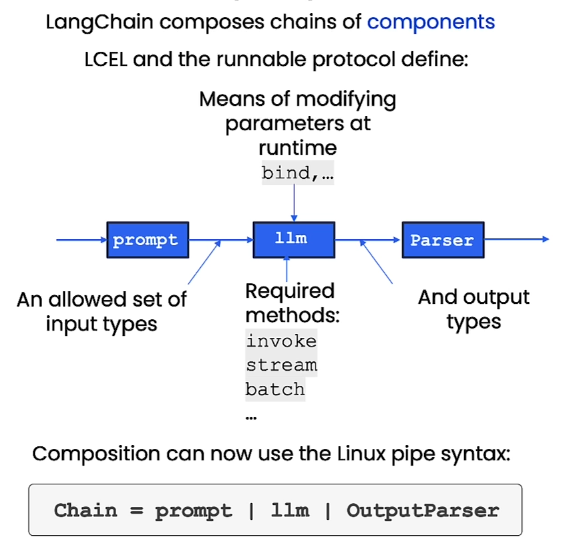
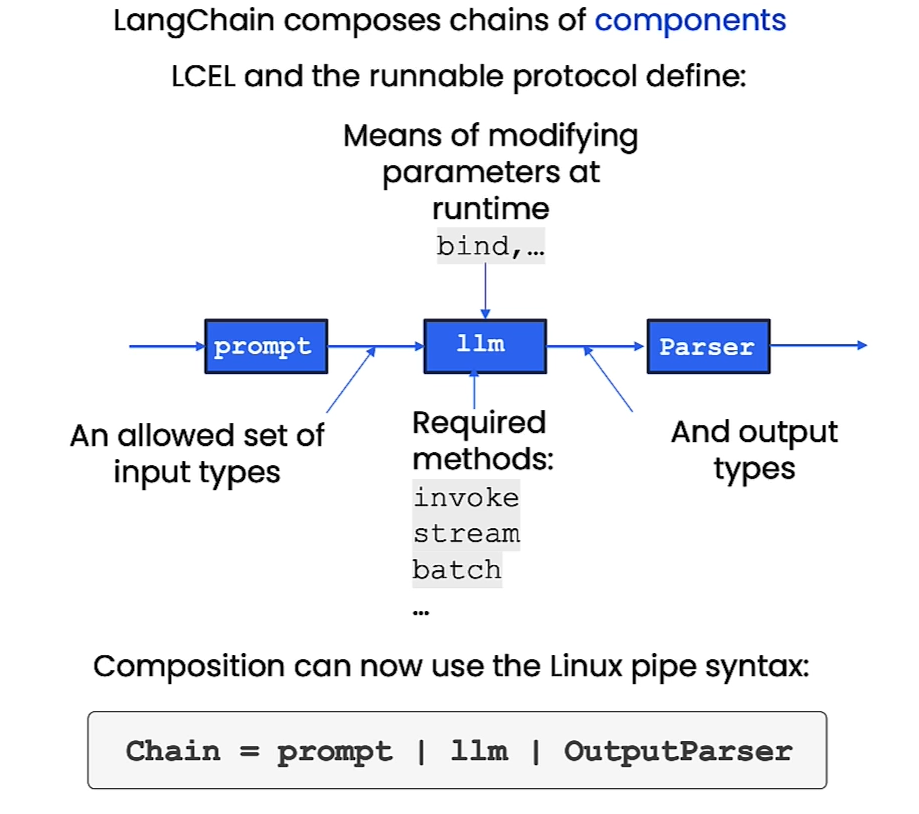

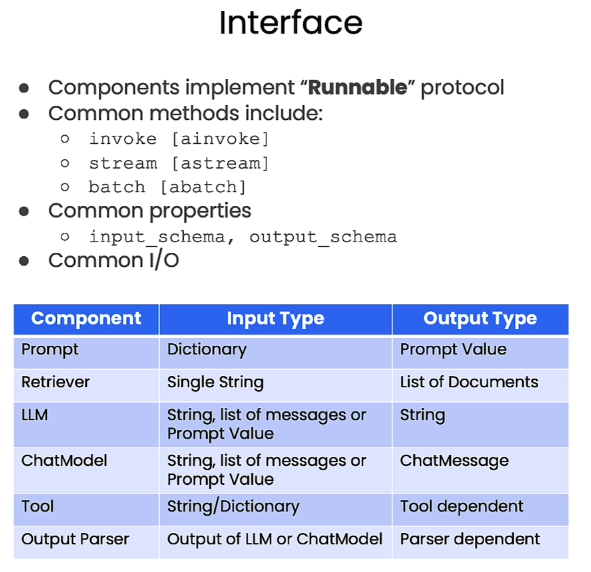

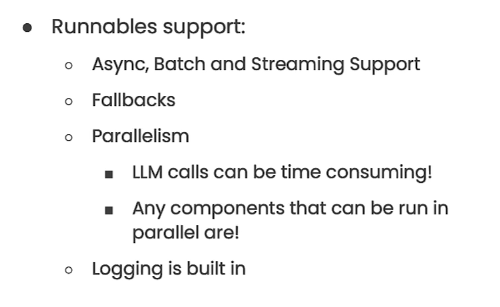

In [119]:
pydantic

NameError: name 'pydantic' is not defined

In [120]:
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

azure_openai_api_key = os.getenv("AZURE_OPENAI_API_KEY_4")
azure_openai_api_endpoint = os.getenv("AZURE_OPENAI_API_ENDPOINT_4")
deployment_name = os.getenv("AZURE_DEPLOYMENT_NAME_4")

In [121]:
#!pip install pydantic==1.10.8

In [122]:
from langchain.prompts import ChatPromptTemplate
from langchain_openai import AzureChatOpenAI, ChatOpenAI
from langchain.schema.output_parser import StrOutputParser

## Simple Chain

In [123]:
prompt = ChatPromptTemplate.from_template(
    "tell me a short joke about {topic}"
)
model = AzureChatOpenAI(api_key=azure_openai_api_key,
                        api_version="2023-12-01-preview",
                        azure_endpoint=azure_openai_api_endpoint,
                        model=deployment_name,
                        temperature=0
                        )

# model = ChatOpenAI(temperature=0)
output_parser = StrOutputParser()

In [124]:
chain = prompt | model | output_parser

In [125]:
chain.invoke({"topic": "bears"})

"Why don't bears wear shoes?\n\nBecause they prefer bear feet!"

## More complex chain

And Runnable Map to supply user-provided inputs to the prompt.

In [126]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import DocArrayInMemorySearch

In [127]:
vectorstore = DocArrayInMemorySearch.from_texts(
    ["harrison worked at kensho", "bears like to eat honey"],
    embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()

In [128]:
retriever.get_relevant_documents("where did harrison work?")

[Document(metadata={}, page_content='harrison worked at kensho'),
 Document(metadata={}, page_content='bears like to eat honey')]

In [129]:
retriever.get_relevant_documents("what do bears like to eat")

[Document(metadata={}, page_content='bears like to eat honey'),
 Document(metadata={}, page_content='harrison worked at kensho')]

In [130]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

In [131]:
from langchain.schema.runnable import RunnableMap

In [132]:
chain = RunnableMap({
    "context": lambda x: retriever.get_relevant_documents(x["question"]),
    "question": lambda x: x["question"]
}) | prompt | model | output_parser

In [133]:
chain.invoke({"question": "where did harrison work?"})

'Harrison worked at Kensho.'

In [134]:
inputs = RunnableMap({
    "context": lambda x: retriever.get_relevant_documents(x["question"]),
    "question": lambda x: x["question"]
})

In [135]:
inputs.invoke({"question": "where did harrison work?"})

{'context': [Document(metadata={}, page_content='harrison worked at kensho'),
  Document(metadata={}, page_content='bears like to eat honey')],
 'question': 'where did harrison work?'}

## Bind

and OpenAI Functions

In [136]:
functions = [
    {
      "name": "weather_search",
      "description": "Search for weather given an airport code",
      "parameters": {
        "type": "object",
        "properties": {
          "airport_code": {
            "type": "string",
            "description": "The airport code to get the weather for"
          },
        },
        "required": ["airport_code"]
      }
    }
  ]

In [137]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}")
    ]
)
model = AzureChatOpenAI(api_key=azure_openai_api_key,
                        api_version="2023-12-01-preview",
                        azure_endpoint=azure_openai_api_endpoint,
                        model=deployment_name,
                        temperature=0
).bind(functions=functions)

In [138]:
runnable = prompt | model

In [139]:
runnable.invoke({"input": "what is the weather in sf"})

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"airport_code":"SFO"}', 'name': 'weather_search'}, 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 62, 'total_tokens': 78, 'completion_tokens_details': None}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_67802d9a6d', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {}}], 'finish_reason': 'function_call', 'logprobs': None, 'content_filter_results': {}}, id='run-a6c2d2d7-8e7f-4281-b1e0-419f5b327072-0', usage_metadata={'input_tokens': 62, 'output_tokens': 16, 'total_tokens': 78})

In [140]:
functions = [
    {
      "name": "weather_search",
      "description": "Search for weather given an airport code",
      "parameters": {
        "type": "object",
        "properties": {
          "airport_code": {
            "type": "string",
            "description": "The airport code to get the weather for"
          },
        },
        "required": ["airport_code"]
      }
    },
        {
      "name": "sports_search",
      "description": "Search for news of recent sport events",
      "parameters": {
        "type": "object",
        "properties": {
          "team_name": {
            "type": "string",
            "description": "The sports team to search for"
          },
        },
        "required": ["team_name"]
      }
    }
  ]

In [141]:
model = model.bind(functions=functions)

In [142]:
runnable = prompt | model

In [143]:
runnable.invoke({"input": "how did the patriots do yesterday?"}, function_call={"name":"weather_search"})

TypeError: BasePromptTemplate.invoke() got an unexpected keyword argument 'function_call'

## Fallbacks

In [144]:
from langchain.llms import OpenAI
import json

In [145]:
# use of an old llm so that it fails at creating a json
simple_model = OpenAI(
    temperature=0, 
    max_tokens=1000, 
    model="gpt-3.5-turbo-instruct"
)
simple_chain = simple_model | json.loads

In [146]:
challenge = "write three poems in a json blob, where each poem is a json blob of a title, author, and first line"

In [147]:
simple_model.invoke(challenge)

'\n\n{\n    "title": "Autumn Leaves",\n    "author": "Emily Dickinson",\n    "first_line": "The leaves are falling, one by one"\n}\n\n{\n    "title": "The Ocean\'s Song",\n    "author": "Pablo Neruda",\n    "first_line": "I hear the ocean\'s song, a symphony of waves"\n}\n\n{\n    "title": "A Winter\'s Night",\n    "author": "Robert Frost",\n    "first_line": "The snow falls softly, covering the ground"\n}'

**Note**: The next line is expected to fail.

In [148]:
simple_chain.invoke(challenge)

JSONDecodeError: Extra data: line 9 column 1 (char 125)

In [149]:
model = ChatOpenAI(temperature=0)
chain = model | StrOutputParser() | json.loads

In [150]:
chain.invoke(challenge)

{'poem1': {'title': 'The Night Sky',
  'author': 'Emily Dickinson',
  'firstLine': 'The night is starry and the stars are blue.'},
 'poem2': {'title': 'Autumn Leaves',
  'author': 'Robert Frost',
  'firstLine': "My sorrow, when she's here with me, thinks these dark days of autumn rain are beautiful as days can be."},
 'poem3': {'title': 'Hope is the Thing with Feathers',
  'author': 'Emily Dickinson',
  'firstLine': 'Hope is the thing with feathers that perches in the soul.'}}

In [106]:
final_chain = simple_chain.with_fallbacks([chain])

In [107]:
final_chain.invoke(challenge)

{'poem1': {'title': 'The Rose',
  'author': 'Emily Dickinson',
  'firstLine': 'A rose by any other name would smell as sweet'},
 'poem2': {'title': 'The Road Not Taken',
  'author': 'Robert Frost',
  'firstLine': 'Two roads diverged in a yellow wood'},
 'poem3': {'title': 'Hope is the Thing with Feathers',
  'author': 'Emily Dickinson',
  'firstLine': 'Hope is the thing with feathers that perches in the soul'}}

## Interface

In [151]:
prompt = ChatPromptTemplate.from_template(
    "Tell me a short joke about {topic}"
)
model = ChatOpenAI()
output_parser = StrOutputParser()

chain = prompt | model | output_parser

In [152]:
chain.invoke({"topic": "bears"})

"Why did the bear break up with his girlfriend? \nBecause he couldn't bear the relationship anymore!"

In [153]:
chain.batch([{"topic": "bears"}, {"topic": "frogs"}])

["Why don't bears like fast food?\n\nBecause they can't catch it!",
 'Why did the frog take the bus to work? Because his car got toad away!']

In [111]:
for t in chain.stream({"topic": "bears"}):
    print(t)


Why
 did
 the
 bear
 break
 up
 with
 his
 girlfriend
?
 


Because
 he
 couldn
't
 bear
 the
 relationship
 any
 longer
!



In [112]:
for t in chain.stream({"topic": "bears"}):
    print(t, end="|", flush=True)

|Why| do| bears| have| hairy| coats|?

|F|ur| protection|!||

In [113]:
response = await chain.ainvoke({"topic": "bears"})
response

'Why did the bear bring a flashlight to the party?\nBecause he heard it was going to be a "beary" good time!'

In [170]:
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.documents import Document
from langchain_core.messages.base import BaseMessage
from langchain_core.messages.ai import AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel, Field
from operator import itemgetter
from typing import List
from langchain_core.runnables import (
    RunnableLambda,
    ConfigurableFieldSpec,
    RunnablePassthrough,
)


prompt = ChatPromptTemplate.from_messages([
    ("system", "You're an assistant who's good at {ability}"),
    MessagesPlaceholder(variable_name="history"),
    ("human", "{question}"),
])

chain = prompt | ChatOpenAI()



class InMemoryHistory(BaseChatMessageHistory, BaseModel):
    """In memory implementation of chat message history."""

    messages: List[BaseMessage] = Field(default_factory=list)

    def add_messages(self, messages: List[BaseMessage]) -> None:
        """Add a list of messages to the store"""
        self.messages.extend(messages)

    def clear(self) -> None:
        self.messages = []


store = {}

def get_by_session_id(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = InMemoryHistory()
    return store[session_id]


history = get_by_session_id("1")
history.add_message(AIMessage(content="hello"))
print(store)  # noqa: T201



{'1': InMemoryHistory(messages=[AIMessage(content='hello', additional_kwargs={}, response_metadata={})])}


In [165]:
chain_with_history = RunnableWithMessageHistory(
    chain,
    # Uses the get_by_session_id function defined in the example
    # above.
    get_by_session_id,
    input_messages_key="question",
    history_messages_key="history",
)

In [166]:
print(chain_with_history.invoke(  # noqa: T201
    {"ability": "math", "question": "What does cosine mean?"},
    config={"configurable": {"session_id": "foo"}}
))


content='Cosine is a trigonometric function that represents the ratio of the adjacent side of a right triangle to its hypotenuse. In simpler terms, it is a function that relates the lengths of the sides of a right triangle to the measure of one of its acute angles. The cosine function is denoted as cos and is commonly used in mathematics and physics to solve problems involving angles and distances.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 25, 'total_tokens': 104, 'completion_tokens_details': {'reasoning_tokens': 0}, 'prompt_tokens_details': {'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-a5d57836-e3cf-4c19-bdab-a718f1381226-0' usage_metadata={'input_tokens': 25, 'output_tokens': 79, 'total_tokens': 104}


In [167]:
# Uses the store defined in the example above.
print(store)  # noqa: T201

{'1': InMemoryHistory(messages=[AIMessage(content='hello', additional_kwargs={}, response_metadata={})]), 'foo': InMemoryHistory(messages=[HumanMessage(content='What does cosine mean?', additional_kwargs={}, response_metadata={}), AIMessage(content='Cosine is a trigonometric function that represents the ratio of the adjacent side of a right triangle to its hypotenuse. In simpler terms, it is a function that relates the lengths of the sides of a right triangle to the measure of one of its acute angles. The cosine function is denoted as cos and is commonly used in mathematics and physics to solve problems involving angles and distances.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 25, 'total_tokens': 104, 'completion_tokens_details': {'reasoning_tokens': 0}, 'prompt_tokens_details': {'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='ru

In [168]:
print(chain_with_history.invoke(  # noqa: T201
    {"ability": "math", "question": "What's its inverse"},
    config={"configurable": {"session_id": "foo"}}
))

content='The inverse of the cosine function is called the arccosine function, denoted as arccos or cos^-1. It is the inverse trigonometric function that takes a ratio value (between -1 and 1) and returns the corresponding angle in radians. The arccosine function is used to find the angle whose cosine is a given value, allowing us to solve for angles in trigonometric equations and applications.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 116, 'total_tokens': 204, 'completion_tokens_details': {'reasoning_tokens': 0}, 'prompt_tokens_details': {'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-afc681a3-b115-4731-9839-3147d93b33df-0' usage_metadata={'input_tokens': 116, 'output_tokens': 88, 'total_tokens': 204}
